In [2]:
import pandas as pd
import lightgbm
import time

In [3]:
test = pd.read_csv('../sale-prediction/test.csv')
data = pd.read_csv('../sale-prediction/data.csv')
data

,date_block_num,shop_id,item_id,item_cnt_month,month,city,item_category_id
0,0,2,19,0.0,0,Adygea,40
1,0,3,19,0.0,0,Balashikha,40
2,0,4,19,0.0,0,Volzhsky,40
3,0,6,19,0.0,0,Voronezh,40
4,0,7,19,0.0,0,Voronezh,40
...,...,...,...,...,...,...,...
11128045,34,49,12470,NaN,10,Tyumen,58
11128046,34,39,12470,NaN,10,RostovNaDon,58
11128047,34,48,12470,NaN,10,Tomsk,58
11128048,34,34,12470,NaN,10,N.Novgorod,58


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_month    float64
 4   month             int64  
 5   city              object 
 6   item_category_id  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 594.3+ MB


In [5]:
data.city.astype('category')

0                Adygea
1            Balashikha
2              Volzhsky
3              Voronezh
4              Voronezh
               ...     
11128045         Tyumen
11128046    RostovNaDon
11128047          Tomsk
11128048     N.Novgorod
11128049    Novosibirsk
Name: city, Length: 11128050, dtype: category
Categories (31, object): [Adygea, Balashikha, Chekhov, Digital, ..., Voronezh, Yakutsk, Yaroslavl, Zhukovsky]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int64  
 1   shop_id           int64  
 2   item_id           int64  
 3   item_cnt_month    float64
 4   month             int64  
 5   city              object 
 6   item_category_id  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 594.3+ MB


In [7]:
city_label={}
cities = data.city.unique()
for i, v in enumerate(cities):
    city_label[v] = i

columns=[['city', 'city_num']]
city_labels = pd.DataFrame.from_dict(city_label,orient='index').reset_index()
city_labels.columns = ['city', 'city_num']
data = data.merge(city_labels, on='city')


In [8]:
data.drop('city', axis=1, inplace=True)
data

,date_block_num,shop_id,item_id,item_cnt_month,month,item_category_id,city_num
0,0,2,19,0.0,0,40,0
1,0,2,27,1.0,0,19,0
2,1,2,27,0.0,1,19,0
3,2,2,27,0.0,2,19,0
4,3,2,27,0.0,3,19,0
...,...,...,...,...,...,...,...
11128045,27,33,21482,0.0,3,64,30
11128046,27,33,21656,0.0,3,40,30
11128047,27,33,21657,0.0,3,37,30
11128048,27,33,21698,0.0,3,40,30


In [9]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'],axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [86]:
# kaggle スタートブックより写経
ts=time.time()

categorical_features = ['shop_id', 'item_id', 'item_category_id', 'city_num', 'month']
lgb_train = lightgbm.Dataset(X_train, Y_train,
                             categorical_feature=categorical_features)
lgb_eval = lightgbm.Dataset(X_valid, Y_valid,
                            categorical_feature=categorical_features)
#https://www.kaggle.com/koyohoriuchi/starter-code-with-feature-eng-and-lgbm-lb-0-899/edit
params = {'objective' : 'regression',
          'metric' : 'rmse',
          'n_estimators' : 10000,
          'early_stopping_rounds':100,
          "num_leaves" : 150,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,
          "feature_fraction" : 0.3,
          "bagging_seed" : 0}

model = lightgbm.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=1000)

time.time() - ts

C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	training's rmse: 2.54188	valid_1's rmse: 4.99423


272.88215613365173

In [87]:
ts = time.time()

Y_test = model.predict(X_test)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('lgbm_1_sub.csv', index=False)

#2.75688

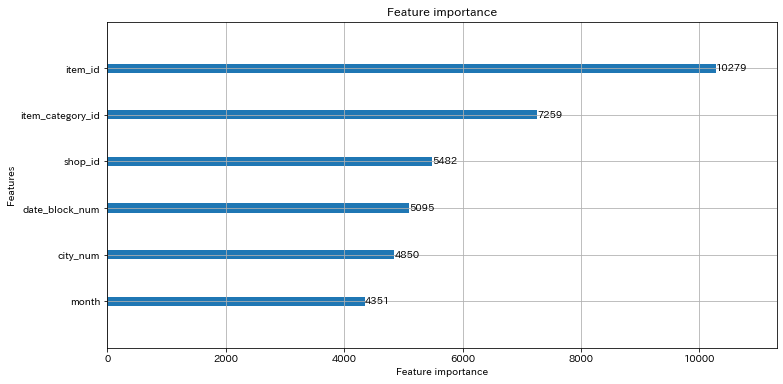

In [90]:
lightgbm.plot_importance(model, figsize=(12, 6))

In [10]:
ts=time.time()

categorical_features = ['shop_id', 'item_id', 'item_category_id', 'city_num', 'month', 'date_block_num']
lgb_train = lightgbm.Dataset(X_train, Y_train,
                             categorical_feature=categorical_features)
lgb_eval = lightgbm.Dataset(X_valid, Y_valid,
                            categorical_feature=categorical_features)
#https://www.kaggle.com/koyohoriuchi/starter-code-with-feature-eng-and-lgbm-lb-0-899/edit
params = {'objective' : 'regression',
          'metric' : 'rmse',
          'n_estimators' : 10000,
          'early_stopping_rounds':100,
          "num_leaves" : 150,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,
          "feature_fraction" : 0.3,
          "bagging_seed" : 0}

model = lightgbm.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=1000)

time.time() - ts

C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\user\Anaconda\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[274]	training's rmse: 2.5415	valid_1's rmse: 4.99452


265.11413860321045

In [11]:
ts = time.time()

Y_test = model.predict(X_test)

time.time() - ts
sub = pd.DataFrame({'ID': test.index,
                    'item_cnt_month': Y_test})

sub.to_csv('lgbm_2_sub.csv', index=False)
#2.75608

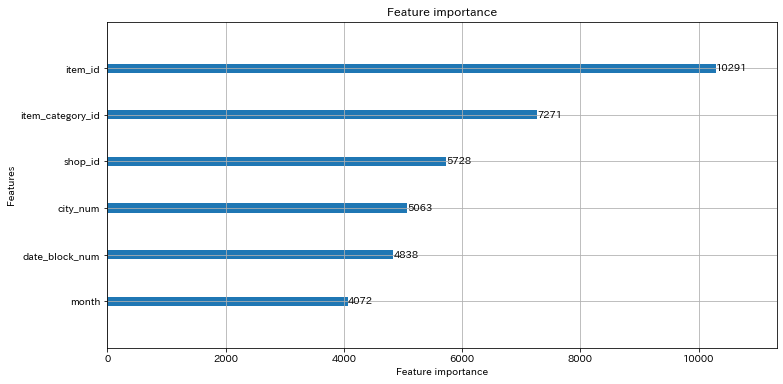

In [12]:
lightgbm.plot_importance(model, figsize=(12, 6))